In [1]:
import sys
sys.path.append("../../src")

import yaml
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
from utils import num_params

# Load the configuration
file_path = "config.yaml"
with open(file_path, 'r') as file:
    config = OmegaConf.create(yaml.safe_load(file))

import torch
import numpy as np
torch.manual_seed(config.seed)
np.random.seed(config.seed)

In [2]:
from ckconv import KernelNet, CKConv

model = KernelNet(
    out_channels=1,
    hidden_channels=config.hidden_channels,
    activation=config.activation,
    bias=True,
    omega_0=config.omega_0,
)

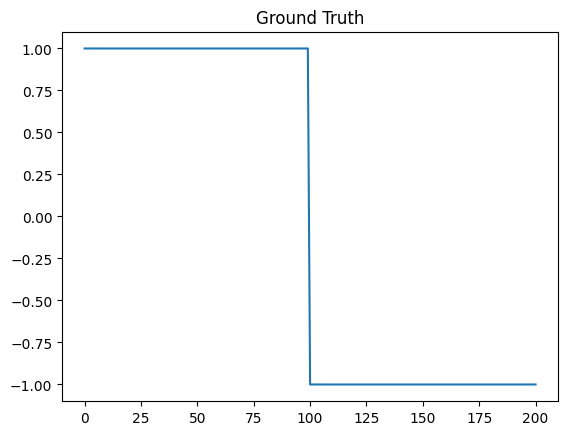

In [3]:
from functions import example_function

function = example_function(config)
plt.plot(function)
plt.title("Ground Truth")
plt.show()

# input to the model
x: torch.Tensor = ( torch
     .linspace(config.min, config.max, config.samples)
     .type(torch.FloatTensor)
     .unsqueeze(0)
     .unsqueeze(0)
)

# actual output of the target function
f: torch.Tensor = ( torch
     .from_numpy(function)
     .type(torch.FloatTensor)
     .unsqueeze(0)
     .unsqueeze(0) 
)

Loss: 0.00000091: 100%|██████████| 15000/15000 [00:21<00:00, 690.73it/s]


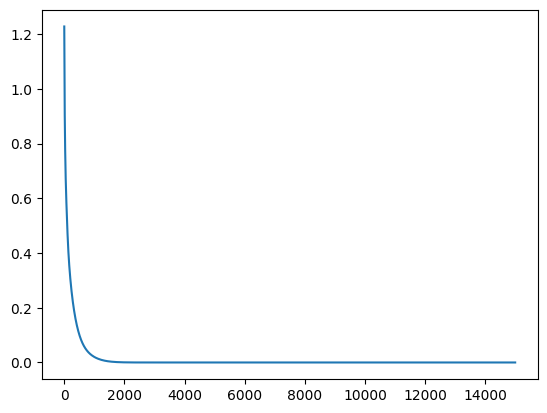

In [4]:
from tqdm import tqdm
from utils import plot_fitted_kernel
from matplotlib.animation import FuncAnimation

lr = config.lr
optimizer = getattr(torch.optim, config.optim)(model.parameters(), lr=lr)
total_loss = 0
train_losses = []


with tqdm(range(config.iterations)) as pbar:
    for i in pbar:
        model.train()
        optimizer.zero_grad()
        output = model(x)
        loss = torch.nn.functional.mse_loss(output,f)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.8f}")

plt.figure()
plt.plot(train_losses)
plt.show()

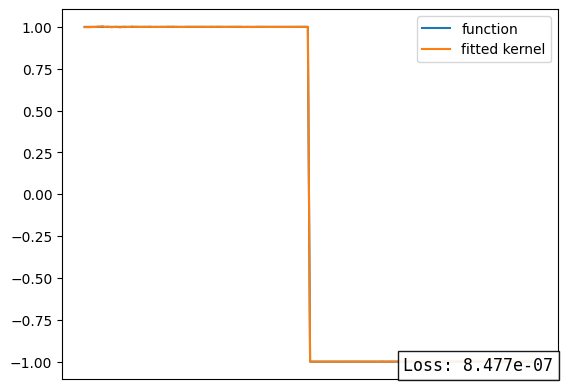

In [5]:
from utils import plot_fitted_kernel

kernelfig = plt.figure()
model.eval()
with torch.no_grad():
    output = model(x)
    loss = torch.nn.functional.mse_loss(output, f)
    plot_fitted_kernel(
        kernelfig,
        output.detach().cpu().squeeze().numpy(),
        f.detach().cpu().squeeze().numpy(),
        loss,
        config
    )
    plt.show()